# The CESM slab ocean model

### About this document

This is actually something called an iPython notebook, which we will probably be using throughout the term. Basically it's a mixture of text and Python code that can be executed inside a web browers. The adventurous and/or computer-literate among you might like to do some googling to learn about iPython notebooks and why they are useful. When you installed Canopy you also installed the capability to create and run these notebooks yourself on your own computer.

You have a choice to either input the code from this document by hand into your Canopy environment, OR figure out how to run this document directly with iPython. The output should be the same either way.

## About the model

We are using a version of the Community Earth System Model (CESM) which is developed and maintained at the National Center for Atmospheric Research in Boulder, CO. See the CESM website here: http://www2.cesm.ucar.edu

Our experiments will use CESM in the so-called "Slab Ocean Model" mode, in which the ocean is represented by a static layer of water with some heat capacity but no motion. This greatly simplifies the necessary calculations, particularly the time required for the model to reach equilibrium. The net effect heat transport by ocean currents is prescribed through a so-called "q-flux", which really just means we prescribed sources and sinks of heat at different locations. For (lots of) details, see http://www2.cesm.ucar.edu/working-groups/pwg/documentation/cesm1-paleo-toolkit/ocean/som

The atmosphere runs on a grid with resolution of about 2º (latitude-longitude), and 26 levels in the vertical. The land model uses the same 2º horizontal grid. The sea ice and ocean models use a finer grid, about 1º.

The model runs on one of our local compute clusters here at U. Albany. We can simulate about 5 years per day by running the model on 32 cores. Equilibration time for the slab ocean model is roughly 20 years. Thus it takes a few days to run any particularly scenario out to equilibrium. The atmospheric GCM uses about half of the cpu time, the sea ice uses about one quarter, and the rest goes to the land model, the coupler, and various other bits and pieces.

We will begin with a "control run", i.e. we will set up the model with (approximately) realistic conditions and run it out to equilibrium. We can then measure how well our simulated climate agrees with observations.

## Description of input

First, let's take a look at some of the ingredients that go into the control run. All of the necessary data will be served up by a special data server sitting in the department, so you should be able to run the code below to interact with the data on any computer that is connected to the internet.

You can browse the available data through a web interface here: http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/Brian+Rose
You should see a folder called CESM runs, and within that folder, another folder called som_input which contains all the input files.

The files are stored in a format called NetCDF. Python has some nice interfaces for working with NetCDF data files, including accessing files remotely over the internet. To begin, we need to import the Python package "netCDF4" to read the data files. The second command may or may not be necessary (depending on the details of your Python setup) to make some special array and graphics tools available to us. It won't hurt anyway.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

Wherever you see an example of Python code like the above in this notebook, you should enter this code into your own Python environment exactly as written. Though of course you are encouraged to experiment and tinker with the code.

### Boundary conditions: continents and topography

Here we are going to load the input topography file and list all the variables in that file. The crazy-looking URL is a link to the data server.

In [2]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )

#topo = nc.Dataset( "http://ramadda.atmos.albany.edu:8080/repository/opendap/9a144a50-a3fe-4790-9952-1bd38642a09f/entry.das" )
for v in topo.variables: print(v)

lat
lon
PHIS
SGH
SGH30
LANDFRAC
LANDM_COSLAT


The output of our little for loop is a list of variable names contained in the file we just opened. Each variables contains some data along with a bunch of descriptive information about the data. Here's an example:

In [3]:
print topo.variables['PHIS']

<type 'netCDF4._netCDF4.Variable'>
float64 PHIS(lat, lon)
    _FillValue: 1e+36
    missing_value: 1e+36
    long_name: surface geopotential
    units: m2/s2
    from_hires: true
    filter: remap
unlimited dimensions: 
current shape = (96, 144)
filling off



This shows the syntax for reading a particular variable, which in this code is the surface geopotential (from which we can get surface elevation). It will be handy to store the grid information (latitude and longitude) in some local arrays. The example below shows that by adding [:] at the end of the expression, we reference just the data itself and not the accompanying decription.

In [4]:
lat = topo.variables['lat'][:]
lon = topo.variables['lon'][:]
print lat.shape, lon.shape

(96,) (144,)


Now we have made local copies of these two arrays that contain coordinate information for the actual data in the file. The .shape command used above gives us information about the dimensions of the arrays, in this case, 96 latitude points and 144 longitude points. If you like can also try just typing "print lat or "print lon and see the coordinates themselves.

We will now read the geopotential and make a plot of the topography of the Earth's surface as represented on the 2º grid. The code below makes a colorful plot of the topography. We also use the land-sea mask in order to plot nothing at grid points that are entirely ocean-covered. Execute this code exactly as written first, and then play around with it to see how you might customize the graph. Note that the function pcolormesh does most of the work here. It's a function that makes color 2D plots of an array.

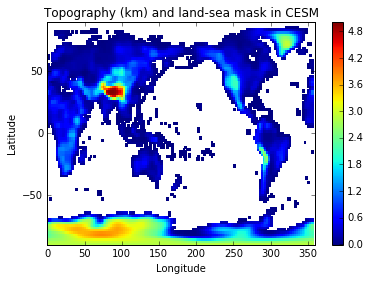

In [5]:
height = topo.variables['PHIS'][:] / 9.8 / 1000  # in meters
height_masked = np.ma.MaskedArray(height, topo.variables['LANDFRAC'][:] == 0. )
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
cax1 = ax1.pcolormesh( lon, lat, height_masked )
ax1.set_title('Topography (km) and land-sea mask in CESM')
ax1.axis([0, 360, -90, 90])
ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude');
cbar1 = plt.colorbar(cax1);

Note that at 2º resolution we can see many smaller features (e.g. Pacific islands). The model is given a fractional land cover for each grid point. Here let's plot the land-sea mask itself so we can see where there is at least "some" water:

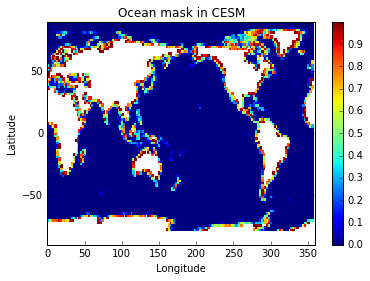

In [6]:
ocean_mask = np.ma.MaskedArray( topo.variables['LANDFRAC'][:], topo.variables['LANDFRAC'][:] == 1. )
fig2 = plt.figure()
ax2 = fig2.add_subplot(1, 1, 1)
cax2 = ax2.pcolormesh( lon, lat, ocean_mask )
ax2.set_title('Ocean mask in CESM')
ax2.axis([0, 360, -90, 90])
ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude')
cbar2 = plt.colorbar(cax2);

### Ocean boundary conditions

Let's look at another immportant input file containing information about the slab ocean. You can see this file in the data catalog here: http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/Brian+Rose/CESM+runs/som_input/pop_frc.1x1d.090130.nc?entryid=1c86bd86-871e-45c0-9cb4-80d1c8648d40

Getting the correct hyperlink to read the data from the server is a bit tricky (we'll work on simplifying that later). Here's what you have to do:

- click on the little down-arrow button in the upper left corner of the window

- under File, select "all services"

- now you see, under Links, at the end of the list, a button for OPeNDAP. Click on that.

- You will now see a bunch of information about the data file on the screen. 

Just copy the URL from your web browser address bar. Hopefully it will be the following:
http://ramadda.atmos.albany.edu:8080/repository/opendap/1c86bd86-871e-45c0-9cb4-80d1c8648d40/entry.das.

We will use this URL to access the data over the internet:

In [7]:
#som_input = nc.Dataset( "http://ramadda.atmos.albany.edu:8080/repository/opendap/1c86bd86-871e-45c0-9cb4-80d1c8648d40/entry.das" )

som_input = nc.Dataset( datapath + 'som_input/pop_frc.1x1d.090130.nc' + endstr )
for v in som_input.variables: print v

area
mask
yc
xc
time
S
T
U
V
dhdx
dhdy
hblt
qdp


The ocean / sea ice models exist on different grids than the atmosphere (1º instead of 2º resolution). Let's store the new coordinate information just like we did for the atmosphere grid.

In [8]:
lon_som = som_input.variables['xc'][:]
lat_som = som_input.variables['yc'][:]
print lon_som.shape, lat_som.shape

(360,) (180,)


Now we are going to look at the annual mean heat flux out of the ocean, which is the prescribed 'q-flux' that we give to the slab ocean model.
It is stored in the field 'qdp' in the input file. The sign convention in CESM is that qdp > 0 where heat is going IN to the ocean. We will change the sign to plot heat going OUT of the ocean INTO the atmosphere (a more atmosphere-centric viewpoint). First, let's just look at the size of the data array:

In [9]:
np.shape(som_input.variables['qdp'][:])

(12, 180, 360)

This means that there are 12 x 180 x 360 data points. One 180 x 360 grid for each calendar month!

Now we are going to take the average over the year at each point. We will use a very convenient array function np.mean(), which just computes the mean point-by-point. This leaves us with a single grid on 180 latitude points by 360 longitude points:

In [10]:
qdp_an = np.mean( som_input.variables['qdp'][:], axis=0 )
print qdp_an.shape

(180, 360)


Now make a nice plot of the annual mean q-flux. This code also overlays a contour of the land-sea mask for reference. 

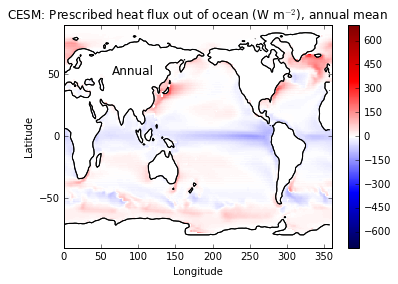

In [11]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
cax3 = ax3.pcolormesh( lon_som, lat_som, -qdp_an, cmap=plt.cm.seismic, vmin=-700., vmax=700. )
cbar3 = plt.colorbar(cax3)
plt.title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$), annual mean' )
plt.axis([0, 360, -90, 90])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5,0.5], colors='k');
ax3.text(65, 50, 'Annual', fontsize=12 );

Notice all the spatial structure here: lots of heat is going in to the oceans at the equator, particularly in the eastern Pacific Ocean. The red hot spots show where lots of heat is coming out of the ocean -- particularly in the mid-latitudes off the eastern coasts of Asia and North America, as well as in the northern North Atlantic. All this structure is determined by ocean circulation, which we are not modeling here. Instead, we are prescribing these heat flux patterns as an input to the atmosphere.

This pattern changes throughout the year. Recall that we just averaged over all months to make this plot. We might want to look at just one month:

In [12]:
qdp_jan = som_input.variables['qdp'][1,:,:]
qdp_jan.shape

(180, 360)

Here we got just the first month (January) by specifying [1,:,:] after the variable name. This is called slicing or indexing an array. We are saying "give me everything for month number 1". Now make the plot:

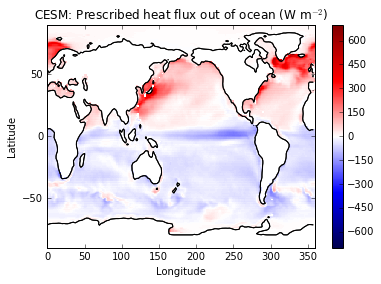

In [13]:
fig4 = plt.figure(); 
ax4 = fig4.add_subplot(111)
cax4 = ax4.pcolormesh( lon_som, lat_som, -qdp_jan, cmap=plt.cm.seismic, vmin=-700., vmax=700. )
cbar4 = plt.colorbar(cax3)
plt.title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)' )
plt.axis([0, 360, -90, 90])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5,0.5], colors='k');
ax3.text(65, 50, 'January', fontsize=12 );

Now try to plot a different month by indexing the array differently. Take a look at how the pattern of heat flux in and out of the oceans changes throughout the year.

## The control run

Output from the control run is available on the same data server as above. Look in the folder called som_control.

There are climatology files for the atmosphere, sea ice, and land surface. I created these files by averaging over the last 10 years of the simulation. Let's take a look at the atmosphere file. You can look up the necessary URL by following the procedure outlined above. The file is called

som_control.cam.h0.clim.nc

(the file extension .nc is used to indicate NetCDF format).

Or just copy the following:

In [14]:
#atm_control = nc.Dataset( "http://ramadda.atmos.albany.edu:8080/repository/opendap/f7a4ac85-623d-4996-be2c-555907cf99b8/entry.das" )
atm_control = nc.Dataset( datapath + 'som_control/som_control.cam.h0.clim.nc' + endstr )

Now we would like to see what's in this file, same as before:

In [15]:
for v in atm_control.variables: print v

lev
hyam
hybm
ilev
hyai
hybi
P0
time
date
datesec
lat
lon
slat
slon
w_stag
time_bnds
date_written
time_written
ntrm
ntrn
ntrk
ndbase
nsbase
nbdate
nbsec
mdt
nlon
wnummax
gw
ndcur
nscur
co2vmr
ch4vmr
n2ovmr
f11vmr
f12vmr
sol_tsi
nsteph
AEROD_v
CLDHGH
CLDICE
CLDLIQ
CLDLOW
CLDMED
CLDTOT
CLOUD
CONCLD
DCQ
DTCOND
DTV
EMIS
FICE
FLDS
FLDSC
FLNS
FLNSC
FLNT
FLNTC
FLUT
FLUTC
FSDS
FSDSC
FSDTOA
FSNS
FSNSC
FSNT
FSNTC
FSNTOA
FSNTOAC
FSUTOA
ICEFRAC
ICIMR
ICWMR
LANDFRAC
LHFLX
LWCF
OCNFRAC
OMEGA
OMEGAT
PBLH
PHIS
PRECC
PRECL
PRECSC
PRECSL
PS
PSL
Q
QFLX
QREFHT
QRL
QRS
RELHUM
SFCLDICE
SFCLDLIQ
SHFLX
SNOWHICE
SNOWHLND
SOLIN
SWCF
T
TAUX
TAUY
TGCLDCWP
TGCLDIWP
TGCLDLWP
TMQ
TREFHT
TS
TSMN
TSMX
U
U10
UU
V
VD01
VQ
VT
VU
VV
Z3


Lots of different stuff! These are all the different quantities that are calculated as part of the model simulation. Every quantity represents a long-term average for a particular month. Want to get more information about a particular variable?

In [16]:
print atm_control.variables['SOLIN']

<type 'netCDF4._netCDF4.Variable'>
float32 SOLIN(time, lat, lon)
    Sampling_Sequence: rad_lwsw
    units: W/m2
    long_name: Solar insolation
    cell_methods: time: mean
unlimited dimensions: time
current shape = (12, 96, 144)
filling off



Apparently this is the incoming solar radiation, with shape (12,96,144) meaning it's got 12 months, 96 latitude points and 144 longitude points. Following the example above from the ocean data, try to make a plot of incoming solar radiation for (1) the annual mean, and (2) one particular month.

### Your task, for now....

Is just to play with the data in this file. Try to figure out what some of the different fields are. Get familiar with the data and with making plots.

Some fields you might want to look at:

- surface temperature, 'TS'

- Outgoing longwave radiation, 'FLNT'

- Net absorbed shortwave, 'FSNT'

These are all 12 x 96 x 144 -- i.e. a two-dimensional grid for every calendar month.

Many other fields are three-dimensional. For example, here is the shape of the array that hold the air temperature at every point and every month:

In [17]:
np.shape( atm_control.variables['T'] )

(12, 26, 96, 144)

And here is some code to plot the average sounding (temperature as function of pressure) at a particular point in the month of January.

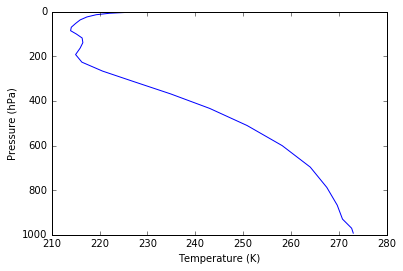

In [18]:
plt.plot( atm_control.variables['T'][1,:,70,115], atm_control.variables['lev'] )
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Temperature (K)')

What was the location we just used for that plot? Let's check by indexing the latitude and longitude arrays we previously stored:

In [19]:
lat[70], lon[115]

(42.631578947368418, 287.5)

These are actually the coordinates of the Albany area (read longitude in degrees east).

### So go ahead and mess around with the model output and see what you can do with it. And have fun.

When we are done it's a good idea to close the data files:

In [20]:
atm_control.close()
som_input.close()
topo.close()

Thanks for playing!